In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

# Model building
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# NLP Libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Initialize nltk stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Load dataset
df = pd.read_csv('../dataset/raw_analyst_ratings.csv')

# Check the first few rows
print(df.head())

# Check dataset information
print(df.info())


   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00     A  
2  2020-05-26 04:30:07-04:00 

In [3]:
from textblob import TextBlob

# Define a function to calculate sentiment
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis
df['sentiment'] = df['headline'].apply(get_sentiment)

# Check sentiment distribution
print(df['sentiment'].value_counts())


sentiment
neutral     934914
positive    341178
negative    131236
Name: count, dtype: int64


In [4]:
# Initialize PorterStemmer and stopwords
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Function for text cleaning
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and special characters
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    text = ' '.join(ps.stem(word) for word in text.split())  # Apply stemming
    return text

# Apply cleaning
df['cleaned_headline'] = df['headline'].apply(clean_text)

# Check cleaned text
print(df[['headline', 'cleaned_headline']].head())


                                            headline  \
0            Stocks That Hit 52-Week Highs On Friday   
1         Stocks That Hit 52-Week Highs On Wednesday   
2                      71 Biggest Movers From Friday   
3       46 Stocks Moving In Friday's Mid-Day Session   
4  B of A Securities Maintains Neutral on Agilent...   

                                    cleaned_headline  
0                         stock hit week high friday  
1                      stock hit week high wednesday  
2                               biggest mover friday  
3                   stock move friday midday session  
4  b secur maintain neutral agil technolog rais p...  


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Transform the cleaned headlines
X = tfidf_vectorizer.fit_transform(df['cleaned_headline'])

# Check the shape of the transformed data
print(f"Shape of TF-IDF features: {X.shape}")

# Target labels
y = df['sentiment']


Shape of TF-IDF features: (1407328, 5000)


In [6]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data size:", X_train.shape)
print("Testing data size:", X_test.shape)

Training data size: (1125862, 5000)
Testing data size: (281466, 5000)


In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],            # Regularization strength
    'penalty': ['l2'],            # Regularization type (GridSearch doesn't support l1 with lbfgs)
    'solver': ['lbfgs']           # Solver for optimization
}

# Initialize GridSearchCV
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')

# Perform GridSearchCV on training data
grid.fit(X_train, y_train)

# Display the best hyperparameters
print("Best parameters:", grid.best_params_)

# Retrieve the best model
best_lr = grid.best_estimator_

# Evaluate the best model on test data
y_pred_best_lr = best_lr.predict(X_test)

# Print evaluation metrics
print("Optimized Logistic Regression Performance:")
print(classification_report(y_test, y_pred_best_lr))

# Accuracy Score
print("Accuracy:", accuracy_score(y_test, y_pred_best_lr))


Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Optimized Logistic Regression Performance:
              precision    recall  f1-score   support

    negative       0.86      0.71      0.78     26410
     neutral       0.93      0.97      0.95    187016
    positive       0.93      0.85      0.89     68040

    accuracy                           0.92    281466
   macro avg       0.90      0.85      0.87    281466
weighted avg       0.92      0.92      0.92    281466

Accuracy: 0.920811039344006


In [8]:
# Train Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Predictions
y_pred_nb = nb.predict(X_test)

# Evaluation
print("Naive Bayes Performance:")
print(classification_report(y_test, y_pred_nb))

Naive Bayes Performance:
              precision    recall  f1-score   support

    negative       0.86      0.45      0.59     26410
     neutral       0.87      0.96      0.92    187016
    positive       0.84      0.76      0.80     68040

    accuracy                           0.87    281466
   macro avg       0.86      0.73      0.77    281466
weighted avg       0.86      0.87      0.86    281466



In [10]:
# Accuracy comparison
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_best_lr))
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

Logistic Regression Accuracy: 0.920811039344006
Naive Bayes Accuracy: 0.8660300000710566


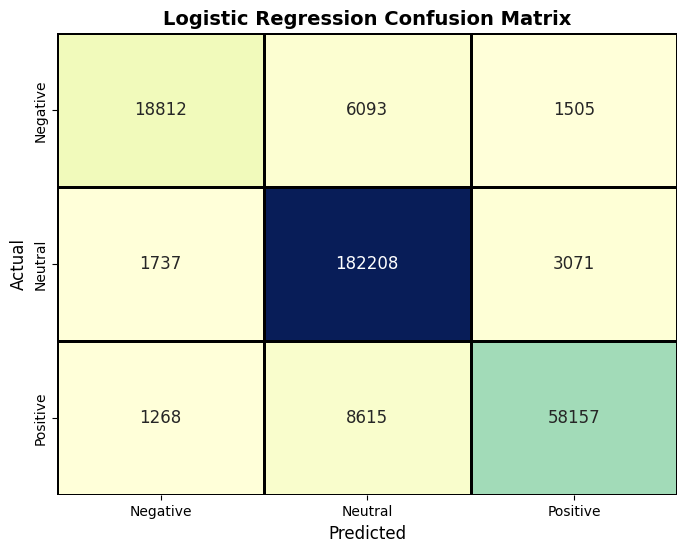

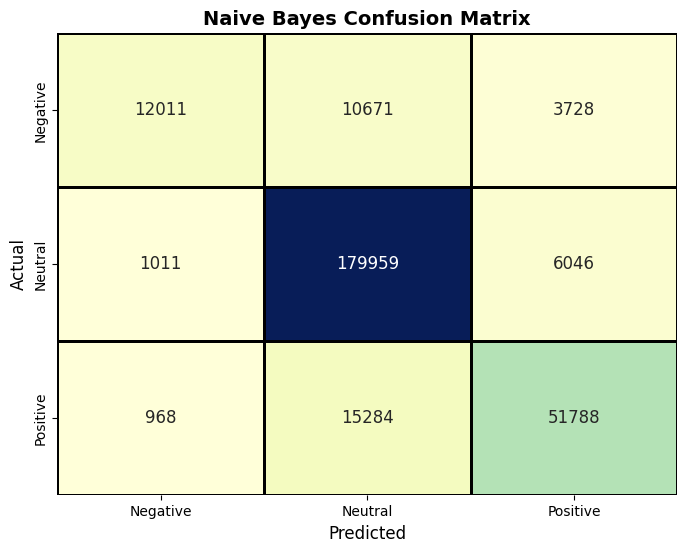

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, title, class_labels=None):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if class_labels is None:
        class_labels = sorted(set(y_true))
    
    plt.figure(figsize=(8, 6))  
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='YlGnBu',  
        xticklabels=class_labels, 
        yticklabels=class_labels,
        linewidths=1,  
        linecolor='black',
        cbar=False,  
        annot_kws={"size": 12}  
    )
    
    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.show()
class_labels = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(y_test, y_pred_best_lr, "Logistic Regression Confusion Matrix", class_labels)
plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes Confusion Matrix", class_labels)